# **CORD2vec - a Coronavirus research tool**

George Yacu, Ethan Sunshine, Sean Seidl - University of Notre Dame - Siegfried Hall

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('0xC5YBOSOio', width=800, height=450)

# Problem:

Amidst the rise of the COVID-19 pandemic, the medical community has seen rapid advances in viral research. New coronavirus literature is published daily at overwhelming amounts, making it challenging for scientists to keep up to date on the most relevant information. To better ensure the successful overcoming of this pandemic, scientists must be able to efficiently sift through the literature to gather necessary insights. An inability to do so would hinder the advancement of combating COVID-19.

# Resources:

[CORD-19](https://www.semanticscholar.org/cord19) is an open research dataset of over 130,000 scholarly articles (69,000 with full text) about the novel coronavirus. The Allen Institute, alongside leading research groups, curates the dataset with articles compatible with machine learning and natural language processing.

# Solution:

Provide an automated tool to read, organize, and filter the most relevant COVID-19 articles from the CORD-19 dataset. The information from these articles will be consolidated into summary tables that concisely and precisely answer targeted questions. With this information, scientists will be able to access key findings without having to read the published articles comprehensively.

# Approach:

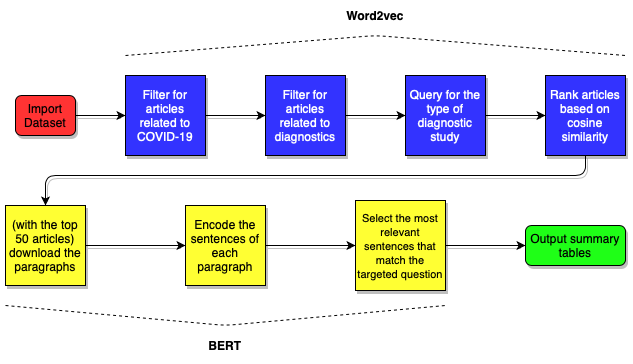

# Models:

**[Word2vec](#Word2vec:)**

**[BERT](#BERT:)**

In [ ]:
import pandas as pd
import numpy as np
from time import time
import json
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import torch
from transformers import AutoTokenizer, AutoModelWithLMHead
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, models
import scipy
from collections import defaultdict

stop_words = set(stopwords.words("english"))

In [ ]:
directory = "/kaggle/input/CORD-19-research-challenge/"

metadata = pd.read_csv(directory + "metadata.csv")
print(metadata.shape)

In [ ]:
pdf_missing, pmc_missing = metadata.pdf_json_files.isnull(), metadata.pmc_json_files.isnull()
fulltext = metadata[~pdf_missing | ~pmc_missing]
print(fulltext.shape)

In [ ]:
stop_words = stopwords.words("english")

def tokenize(text):
    """
        Cleans and tokenizes text
        
        Input:
        text: str to be tokenized
        
        Output:
        list of tokens
    """
    regex = re.compile("\[.*?\]")
    text = regex.sub("", text)
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()
    return [token for token in text.split() if token not in stop_words and token not in punctuation] 

# Word2vec:

Our word2vec model is trained exclusively on CORD-19 abstracts and improves the relevance of the search engine results compared to baseline information retrieval (IR) approaches. The model automatically performs query expansion using the 300-dimensional word embeddings. The model can generalize well to abstracts that are only recently added to the dataset without having to be retrained. Furthermore, the model serves as an effective filter to find articles in the dataset that are only relevant to COVID-19 and various diagnostic studies.

Note: The model was trained for this project in a seperate notebook and then loaded into our final notebook. The model along with the hyper parameters have been made publicly available [here](https://www.kaggle.com/georgeyacu/60k-abstract-w2v).


In [ ]:
class W2VLogger(CallbackAny2Vec):
    
    def __init__(self):
        self.epoch = 1
        self.loss = 0

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        print("Time since start: {}".format((time() - t) / 3560))
        curr_loss = model.get_latest_training_loss() - self.loss
        print('Loss: {}'.format(curr_loss))
        self.loss = curr_loss
        self.epoch += 1

embeddings = Word2Vec.load(directory + '../60k-abstract-w2v/60k_abstracts_w2v.model')


def get_phrase_vector(phrase):
    """
        Concatenates word vectors in phrase
        
        Input:
        phrase: list of str tokens
        
        Output:
        300-dimensional vector representation of phrase
    """
    vector = [0] * 300
    for word in phrase:
        try:
            vector += embeddings.wv[word]
        except:
            pass
        
    return vector


def phrase_cos_similarity(phrase1, phrase2):
    """
        Computes cosine similarity score between phrase1 and phrase2
        
        Input:
        phrase1: list of str tokens
        phrase2: list of str tokens
        
        Output:
        cosine similarity between phrase1 and phrase2
    """
    vec1 = get_phrase_vector(phrase1)
    vec2 = get_phrase_vector(phrase2)
    cos_sim = np.dot(vec1,vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cos_sim


def get_article_similarity(doc_index, query):
    """
        Computes cosine similarity between document title and query
        
        Input:
        doc_index: index in metadata of the document title to be retrieved
        query: list of str tokens
        
        Output:
        cosine similarity between document title and query
    """
    article_name = fulltext['title'][doc_index]
    article_name = tokenize(str(article_name))
    return phrase_cos_similarity(query,article_name)


def rank_similar_articles(corpus, query):
    """
        Ranks the relevance of all documents in the corpus to the query
        
        Input:
        corpus: pandas dataframe with all documents to be ranked
        query: list of str tokens
        
        Output:
        pandas dataframe with all documents in descending order based on cosine similarity to query
    """
    indices = corpus.index.values.tolist()
    similarities = [None] * len(indices)
    for it in tqdm(range(len(indices))):
        index = indices[it]
        similarities[it] = get_article_similarity(index, query)
    corpus['similarity'] = similarities
    return corpus.sort_values('similarity',ascending=False)


def search_corpus(corpus, query, selection_ratio = 0.33):
    """
        Ranks the relevance of all documents in the corpus to the query
        
        Input:
        corpus: pandas dataframe with all documents to be ranked
        query: str to be searched
        selection_ratio: fraction of ranked documents to keep
        
        Output:
        pandas dataframe with selection_ratio of documents in descending order based on cosine similarity to query
    """
    return rank_similar_articles(corpus, query.split()).head(int(corpus.shape[0] * selection_ratio))

In [ ]:
# Filter full text documents for ones only about COVID-19
covidtext = search_corpus(fulltext, "covid-19")
covidtext.shape
# Filter covid-related full text documents for ones only about diagnostic studies
diag_texts = search_corpus(covidtext, "diagnostic")
diag_texts.shape

In [ ]:
relevanttext = search_corpus(diag_texts, "antibody igg imm tests")
print(relevanttext.shape)
relevanttext.head(50)

# BERT:

Originally, we intended to use a BERT model fine tuned for question answering that would provide concise answers. After interviewing several COVID researchers and clinicians in the Notre Dame alumni network, we received feedback to provide a sentence rather than a word to answer the question because it provided valuable context for the answer. For this reason, we used a BERT model based on Deepset’s COVID-BERT and fine-tuned for natural language inference (NLI) tasks. For each document that we wished to summarize, we compared the sentence embeddings from the document with exemplar sentences and computed the cosine similarity between each sentence and exemplar to find the best sentence to answer the question.

Note: The [covidbert-nli](https://huggingface.co/gsarti/covidbert-nli), made publicly available by Gabriele Sarti, was used  in this project.

In [ ]:
# Use BERT for mapping tokens to embeddings
covidbert_nli = models.Transformer("gsarti/covidbert-nli")

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(covidbert_nli.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[covidbert_nli, pooling_model])

In [ ]:
def get_text(paper):
    """
        Gets title, abstract, body paragraphs, and figure captions from paper
        
        Input:
        paper: pandas dataframe row of document to be retrieved
        
        Output:
        str representation of title, abstract, body paragrahs, and figure captions
    """
    try:
        data = open(directory + paper.pdf_json_files.split(";")[0])
    except:
        data = open(directory + paper.pmc_json_files.split(";")[0])
    
    doc = json.load(data)
    data.close()
    
    title, abstract, body, captions = "", "", "", ""
    
    title = doc["metadata"]["title"]
    try:
        for p in doc["abstract"]:
            abstract += p["text"] + " "
    except:
        pass
    
    try:
        for p in doc["body_text"]:
            body += p["text"] + " "
    except:
        pass
    
    try:
        for p in doc["ref_entries"]:
            captions += doc["ref_entries"][p]["text"]
    except:
        pass
    
    return title, abstract, body, captions


def filter_sentences(text, question, topn = 15):
    """
        Returns topn sentences from text that have the lowest word mover's distance from the question
        
        Input:
        text: str representation of full text
        question: str to be compared to sentences of text
        topn: number of relevant sentences to return
        
        Output:
        topn sentences in text that are relevant to question
    """
    result = []
    sents = sent_tokenize(text)
    keywords = tokenize(question)
    
    for sent in sents:
        if (len(sent) < 10) or (len(sent) > 400):
            sents.remove(sent)

    scores = [embeddings.wv.wmdistance(sent.lower(), question.lower()) for sent in sents]
    result = sorted(zip(scores, sents), key = lambda x: x[0], reverse = False)[:topn]

    return result

In [ ]:
def create_summary_table(model, corpus, contexts):
    """
        Creates summary table on 
        
        Input:
        model: BERT NLI model
        corpus: pandas dataframe of documents to be included in summary table
        contexts: list of exemplar sentences that model the question's answer
        
        Output:
        topn sentences in text that are relevant to question
    """
    table = defaultdict(list)
    for i, doc in corpus.iterrows():
        title, abstract, body, captions = get_text(doc)
        
        table["Publication Date"].append(doc.publish_time) 
        table['Study'].append(doc.title)
        table["Study Link"].append(doc.url)
        table["Journal"].append(doc.journal)
  
        query_embeddings = model.encode(contexts)
        for context, query_embedding in zip(contexts, query_embeddings):
            try:
                sentences = filter_sentences(str(abstract + " " + body), context)
                sentences = list(zip(*sentences))[1] #only if you pre rank sentences
                sentence_embeddings = model.encode(sentences)
            
                distances = scipy.spatial.distance.cdist([query_embedding], sentence_embeddings, "cosine")[0]
                results = zip(range(len(distances)), distances)
                results = sorted(results, key=lambda x: x[1], reverse = False) # should not be reverse = true, as scipy implementation is 1 - cos score
        
                for idx, distance in results[:1]:
                    table[context].append(sentences[idx])
            except:
                table[context].append("-")
        
        table["DOI"].append(doc.doi)
        table["CORD_UID"].append(doc.cord_uid)
        
        result = pd.DataFrame(table)
        result.columns = ['Publication Date','Study','Study Link','Journal',
                          'Study Type', 'Detection Method', "Sample Size", 'Specimen Obtained', 'Speed of Assay',
                          "Available for Point-of-Care Use", 'Sample Measure of Evidence', 'FDA Approval', 'DOI', 'CORD_UID']
                
    return result

In [ ]:
contexts = [
    "This is a retrospective and observational study",
    "The antibodies against SARS-CoV-2 were detected by an enzyme-linked immunosorbent assay (ELISA) based on the recombinant nucleocapsid protein of SARS-CoV-2 in patients with confirmed or suspected COVID-19",
    "A total of 323 samples from 76 COVID-19 confirmed patients were analyzed",
    "nasopharyngeal swabs, sputum, blood, feces and anal swabs of COVID-19 cases were collected",
    "run-time of 45-50 minutes with hands on time limited to 2-3 minutes",
    "We believe a point-of-care (PoC) device for the rapid detection of the 2019 novel Coronavirus (SARS-CoV-2) is crucial and urgently needed.",
    "The sensitivity for both IgM and IgG tests ranges between 72.7% and 100%, while specificity ranges between 98.7% to 100% and the positive and negative predictive values were 96.21% and 98.68% respectively.",
    "most molecular tests have been approved by the United States Food and Drug Administration (FDA) under emergency use authorization (EUA) "
]

In [ ]:
pd.set_option('display.max_colwidth', 0)

# Summary Tables:
The summary tables exported as CSVs contain 50 entries, but only the top 10 entries of each summary table were displayed below.

## Nucleic Acid-Based Diagnostics:

Highlights:
* While earlier studies used small sample sizes leading to sometimes inaccurate measures of performance, more recent studies employed larger sample sizes.
* RT-PCR tests are the golden standard for nucleic acid-based diagnostics due to their high sensitivity and specificity; however, these tests take roughly 3-4 hours to perform in addition to skilled technicians and expensive equipment.
* LAMP is a possible nucleic acid test that could be used for point-of-care testing.

In [ ]:
corpus = search_corpus(diag_texts, "nucleic acid tests").iloc[:50]
result_na = create_summary_table(model, corpus, contexts)

In [ ]:
# Display the top 10 results of the summary table
result_na.to_csv("/kaggle/working/diagnosing SARS-COV-2 with nucleic-acid based tech.csv")
result_na.head(10)

## Antibody Diagnostics:

Highlights:
* Antibody tests are useful for rapid, large-scale testing
* Antibody tests might not be suitable for rapid diagnosis of acute COVID-19 infection due to low sensitivity

In [ ]:
corpus = search_corpus(diag_texts, "antibody tests").iloc[:50]
result_ab = create_summary_table(model, corpus, contexts)

In [ ]:
result_ab.to_csv("/kaggle/working/diagnosing SARS-COV-2 with antibodies")
result_ab.head(10)

## Point-of-Care and Rapid Bedside Diagnostics:

Highlights:
* Home-based and point-of-care tests could address a need for accurate diagnostics in developing countries that do not have as much access to laboratory equipment like thermocyclers.
* Point-of-care tests can detect COVID-19 in the oral cavity or nasal cavitiy, which is more comfortable for the patient being tested.

In [ ]:
corpus = search_corpus(diag_texts, "point-of-care and rapid bedside tests").iloc[:50]
result_poc = create_summary_table(model, corpus, contexts)

In [ ]:
result_poc.to_csv("/kaggle/working/development of a point-of-care test and rapid bed-side tests.csv")
result_poc.head(10)

## Viral Load Studies:

In [ ]:
corpus = search_corpus(diag_texts, "viral load").iloc[:50]
result_vl = create_summary_table(model, corpus, contexts)

In [ ]:
result_vl.to_csv("/kaggle/working/how does viral load relate to disease presentations and likelihood of a positive diagnostic test.csv")
result_vl.head(10)

# Pros:

* Word and sentence embeddings do query expansion automatically so we can search similar words
* The models do not take up too much memory
* There is a good amount of context to see where the answers came from
* The tiered w2v model retrieves relevant articles
* The table indicates whether the test is suitable for point-of-care
* The system can be applied to other questions and queries without having to redesign its architecture
* W2v embeddings and pretrained COVID-BERT model can be easily imported for rapid generation/expansion of tables in a matter of minutes
* Semantic search with tiered w2v and bert sentence transformers

# Cons:

* Returned answers could be more concise
* The semantic search results had to be found from online sources rather than using normal questions
* The table has lower recall because the answers are not validated with BERT question answering
* Only compatible with CORD-19 dataset
* The accuracy of certain queries can be improved

# Future Directions:
* Design a UI to complement the search
* Experiment with NER like sciSpacy to compare performance on some questions it could excel bert
* Better data preprocessing step to remove citations and numbers that appear randomly in the text
* Develop a table for studies that compare one diagnostic approach to another

# Acknowledgements:

We would like to thank the following Notre Dame alumni for their time and expert opinions in assessing the functionality of our tool.

Tom Isenbarger ‘93 Ph.D. J.D.

Rich Shea ‘85 MBA

George Christopher ‘74 M.D.

Nathan Cuka ‘92 M.D.

We also would like to thank Gabriele Sarti for making available [his BERT model](https://huggingface.co/gsarti/covidbert-nli) which we tailored towards our tool. 

# Additional Citations:


Chen, Qingyu, et al. “BioSentVec: Creating Sentence Embeddings for Biomedical Texts.” Arxiv.org, 24 Jan. 2020, [arxiv.org/abs/1810.09302](arxiv.org/abs/1810.09302).

Mikolov, Tomas, et al. “Distributed Representations of Words and Phrases and Their Compositionality.” Papers.nips.cc, 2013, [papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf](papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Reimers, Nils, and Iryna Gurevych. “Sentence-BERT: Sentence Embeddings Using Siamese BERT-Networks.” Arxiv.org, 27 Aug. 2019, [arxiv.org/abs/1908.10084](arxiv.org/abs/1908.10084).

Wang, Lucy Lu, et al. “CORD-19: The Covid-19 Open Research Dataset.” Arxiv.org, 22 Apr. 2020, [arxiv.org/abs/2004.10706](arxiv.org/abs/2004.10706).
